In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U keras-tuner


     |████████████████████████████████| 71kB 5.1MB/s 


In [3]:
# Import required packages, libraries and classes for the project

import numpy as np
np.random.seed(1)

import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
from keras.layers import InputLayer, ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.optimizers import Adam, SGD, Nadam
import keras
import kerastuner as kt
plt.style.use('default')

### Data Preprocessing

In [4]:
# Load the Dataset
df = pd.read_csv("/content/drive/My Drive/stock8030.csv",parse_dates = True,index_col=0)
df.head()

,Open,High,Low,Volume,SMA,EMA,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,STOCHD,Close
Date,,,,,,,,,,,,,,,
2014-06-15,32.5,32.8,32.4,482290.0,35.033333,35.273907,-2.1,24.189090,-13.793103,-2.032828,34.945,416347.233313,17.073171,18.031482,32.5
2014-06-16,32.5,32.8,32.4,673690.0,35.280952,35.551298,-2.0,24.385914,-14.435696,-2.039900,35.160,573695.586234,17.021277,19.916183,32.6
2014-06-17,32.6,32.9,31.8,604630.0,35.542857,35.846427,-2.4,24.966341,-14.322917,-2.029438,35.415,587012.596435,20.000000,16.806527,32.9
2014-06-18,32.9,34.1,32.9,1160000.0,35.804762,36.141070,-1.9,27.007018,-12.176166,-2.017111,35.675,331923.711053,22.727273,13.558664,33.9
2014-06-19,34.1,34.4,34.1,724030.0,36.028571,36.365177,-2.3,27.434139,-12.113402,-2.073856,35.900,151906.833214,7.692308,15.384615,34.1


In [5]:
# Correlation Matrix
df.corr()['Close']

Open       0.997722
High       0.998894
Low        0.998913
Volume     0.157783
SMA        0.966208
EMA        0.976025
MOM        0.154007
RSI        0.245332
ROC        0.227390
MACD       0.288514
BB         0.967934
CHAIKIN    0.503953
STOCH      0.109349
STOCHD     0.119068
Close      1.000000
Name: Close, dtype: float64

In [6]:
df.columns

Index(['Open', 'High', 'Low', 'Volume', 'SMA', 'EMA', 'MOM', 'RSI', 'ROC',
       'MACD', 'BB', 'CHAIKIN', 'STOCH', 'STOCHD', 'Close'],
      dtype='object')

In [7]:
# Extracting the features for the ConvLSTM model
series = df[["Close",	"MOM",	"RSI",	"ROC",	"MACD",	"BB",	"CHAIKIN",	"STOCH"]]
print(series.shape)
series.head()

(1460, 8)


,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-15,32.5,-2.1,24.189090,-13.793103,-2.032828,34.945,416347.233313,17.073171
2014-06-16,32.6,-2.0,24.385914,-14.435696,-2.039900,35.160,573695.586234,17.021277
2014-06-17,32.9,-2.4,24.966341,-14.322917,-2.029438,35.415,587012.596435,20.000000
2014-06-18,33.9,-1.9,27.007018,-12.176166,-2.017111,35.675,331923.711053,22.727273
2014-06-19,34.1,-2.3,27.434139,-12.113402,-2.073856,35.900,151906.833214,7.692308


In [8]:
# Normalisation
sc_X = StandardScaler()
series.iloc[:,1:] = sc_X.fit_transform(series.iloc[:,1:])
sc_y = StandardScaler()
series[['Close']] = sc_y.fit_transform(series[['Close']])
series

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-15,-0.121296,-0.372344,-2.289860,-0.807755,-1.042261,0.017282,-0.261939,-1.030382
2014-06-16,-0.115838,-0.355390,-2.273345,-0.839106,-1.045746,0.029196,-0.210433,-1.032087
2014-06-17,-0.099464,-0.423208,-2.224644,-0.833604,-1.040591,0.043327,-0.206074,-0.934240
2014-06-18,-0.044883,-0.338435,-2.053420,-0.728866,-1.034518,0.057735,-0.289574,-0.844653
2014-06-19,-0.033967,-0.406253,-2.017582,-0.725804,-1.062476,0.070203,-0.348500,-1.338530
...,...,...,...,...,...,...,...,...
2020-05-03,-1.004412,-0.921670,-2.123941,-1.443134,-0.523212,-0.808496,-0.019934,-1.497950
2020-05-04,-0.967298,-0.636835,-1.926685,-1.277607,-0.473482,-0.791096,0.161875,-1.145632
2020-05-05,-0.937824,-0.463899,-1.752243,-1.088202,-0.433304,-0.776411,0.181921,-1.117108


In [9]:
# Train/Test Data Split
train_start = dt.date(2014,5,15)
train_end = dt.date(2020,3,1)
train_data = series.loc[train_start:train_end]

test_start = dt.date(2020,3,2)
test_end = dt.date(2020,6,14)
test_data = series.loc[test_start:test_end]

print(train_data.shape,test_data.shape)

(1411, 8) (49, 8)


In [10]:
train = train_data.values
val = test_data.values

In [11]:
# Setting up an Early Stopping function
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]
RMSE = keras.metrics.RootMeanSquaredError()

In [12]:
X_train = []
Y_train = []
X_val = []
Y_val = []
timesteps = 45

# Loop for training data
for i in range(timesteps,train.shape[0]):
  X_train.append(train[i-timesteps:i])
  Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

# Loop for val data
for i in range(timesteps,val.shape[0]):
  X_val.append(val[i-timesteps:i])
  Y_val.append(val[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, X_train.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1, X_val.shape[2], 1)

In [13]:
from keras import backend as K
from keras.losses import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

In [14]:
def model_builder(hp):
  # Define the ConvLSTM Model
  model = Sequential()

  # Input shape: (samples, time, channels, rows, cols) see: https://keras.io/layers/recurrent/#convlstm2d
  hp_filter = hp.Choice('filter', values = [8,16,32])
  model.add(ConvLSTM2D(
          filters=hp_filter,
          kernel_size=(10, 10),
          input_shape=(X_train.shape[1], 1, X_train.shape[3], 1),
          padding='same',
          return_sequences=True))
  model.add(LeakyReLU())
  model.add(BatchNormalization())

  model.add(ConvLSTM2D(
          filters=hp_filter,
          kernel_size=(5, 5),
          padding='same',
          return_sequences=False))
  model.add(LeakyReLU())
  model.add(BatchNormalization())
  hp_dropout = hp.Float('dropout', min_value = .2, max_value = .5, step = .1)

  model.add(Dropout(rate = hp_dropout))

  model.add(Flatten())

  hp_units = hp.Int('units', min_value = 16, max_value = 64, step = 8)
  model.add(Dense(units=hp_units, kernel_initializer='TruncatedNormal'))
  model.add(LeakyReLU())
  model.add(Dropout(rate = hp_dropout))

  model.add(Dense(units=hp_units, kernel_initializer='TruncatedNormal'))
  model.add(LeakyReLU())
  model.add(Dropout(rate = hp_dropout))

  model.add(Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  hp_batch = hp.Choice('batch_size', values = [8,16,64])

  model.compile(optimizer = optimizers.Adam(learning_rate = hp_learning_rate),
                loss = root_mean_squared_error,
                metrics=[root_mean_squared_error,'mse', 'mae', 'mape'])
  
  return model

In [15]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 50,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [16]:
import tensorflow as tf
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [17]:
tuner.search(X_train, Y_train, epochs = 10, validation_data = (X_val, Y_val), callbacks = [ClearTrainingOutput()])


Trial 90 Complete [00h 15m 56s]
val_loss: 0.013421133160591125

Best val_loss So Far: 0.004991680383682251
Total elapsed time: 05h 22m 38s
INFO:tensorflow:Oracle triggered exit


In [18]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.\nThe optimal number of units in the first densely-connected layer is {best_hps.get('units')}\n
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}\n
The best dropout is {best_hps.get('dropout')}\n
The best batch size is {best_hps.get('batch_size')}\n
The best num of epochs is {best_hps.get('tuner/epochs')}\n
The best num of filters is {best_hps.get('filter')}.
""")


The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is 64

The optimal learning rate for the optimizer is 0.01

The best dropout is 0.2

The best batch size is 8

The best num of epochs is 17

The best num of filters is 32.



In [19]:
tuner.results_summary(num_trials=90)

Results summary
Results in my_dir/intro_to_kt
Showing 90 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filter: 32
dropout: 0.2
units: 64
learning_rate: 0.01
batch_size: 8
tuner/epochs: 17
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.004991680383682251
Trial summary
Hyperparameters:
filter: 32
dropout: 0.5000000000000001
units: 56
learning_rate: 0.01
batch_size: 64
tuner/epochs: 17
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.007127285003662109
Trial summary
Hyperparameters:
filter: 32
dropout: 0.2
units: 64
learning_rate: 0.01
batch_size: 8
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 2c3dc7d5b3d0e693393f52f72fa6fa12
Score: 0.011314183473587036
Trial summary
Hyperparameters:
filter: 16
dropout: 0.5000000000000001
units: 56
learning_rate: 0.01
batch_size: 16
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: b2257bcfedeabe68809b

In [20]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, Y_train, epochs = 50, validation_data = (X_val, Y_val))

Epoch 1/50
43/43 [==============================] - 22s 439ms/step - loss: 1.0978 - root_mean_squared_error: 1.0978 - mse: 2.0403 - mae: 1.0978 - mape: 243.8566 - val_loss: 0.8046 - val_root_mean_squared_error: 0.8046 - val_mse: 0.6485 - val_mae: 0.8046 - val_mape: 86.7270
Epoch 2/50
43/43 [==============================] - 19s 453ms/step - loss: 0.4399 - root_mean_squared_error: 0.4399 - mse: 0.3531 - mae: 0.4399 - mape: 155.3452 - val_loss: 0.5005 - val_root_mean_squared_error: 0.5005 - val_mse: 0.2516 - val_mae: 0.5005 - val_mape: 53.9044
Epoch 3/50
43/43 [==============================] - 19s 443ms/step - loss: 0.3377 - root_mean_squared_error: 0.3377 - mse: 0.1917 - mae: 0.3377 - mape: 153.7013 - val_loss: 0.4750 - val_root_mean_squared_error: 0.4750 - val_mse: 0.2262 - val_mae: 0.4750 - val_mape: 51.1806
Epoch 4/50
43/43 [==============================] - 19s 433ms/step - loss: 0.2974 - root_mean_squared_error: 0.2974 - mse: 0.1482 - mae: 0.2974 - mape: 96.6346 - val_loss: 1.0214

In [21]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.title('Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [22]:
# Plotting the training errors
def plot_loss(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [23]:
# Evaluating the model
def evaluate_model(model,X_val):
     # Prediction Time 
    Y_hat = model.predict(X_val)
    return Y_val, Y_hat
  

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 45, 1, 8, 32)      422528    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 45, 1, 8, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 1, 8, 32)      128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 8, 32)          204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1, 8, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 8, 32)          128       
_________________________________________________________________
dropout (Dropout)            (None, 1, 8, 32)          0

In [25]:
y_pred = model.predict(X_val)
y_true = np.array([Y_val]).T

mae = tf.keras.losses.MeanAbsoluteError()
mae = mae(y_true, y_pred).numpy()

mape = tf.keras.losses.MeanAbsolutePercentageError()
mape = mape(y_true, y_pred).numpy()

mse = tf.keras.losses.MeanSquaredError()
mse = mse(y_true, y_pred).numpy()

rmse = sqrt(mse)


In [26]:
print('MSE = {}'.format(round(mse, 5)))
print('RMSE = {}'.format(round(rmse, 5)))
print('MAPE = {}'.format(round(mape, 5)))
print('MAE = {}'.format(round(mae, 5)))

MSE = 0.0010999999940395355
RMSE = 0.0329
MAPE = 3.090399980545044
MAE = 0.028300000354647636


In [27]:
true ,predicted = evaluate_model(model,X_val)

In [28]:
train_date = df['2014-05-15' : '2020-03-1'].index
test_date = df['2020-03-2' :].index
pred_date = df['2020-03-2' :].index[45:]

In [29]:
Y_train = sc_y.inverse_transform(np.array([train[:,0]]))
Y_test = sc_y.inverse_transform(np.array([val[:,0]]))
Y_pred = sc_y.inverse_transform(predicted.T)

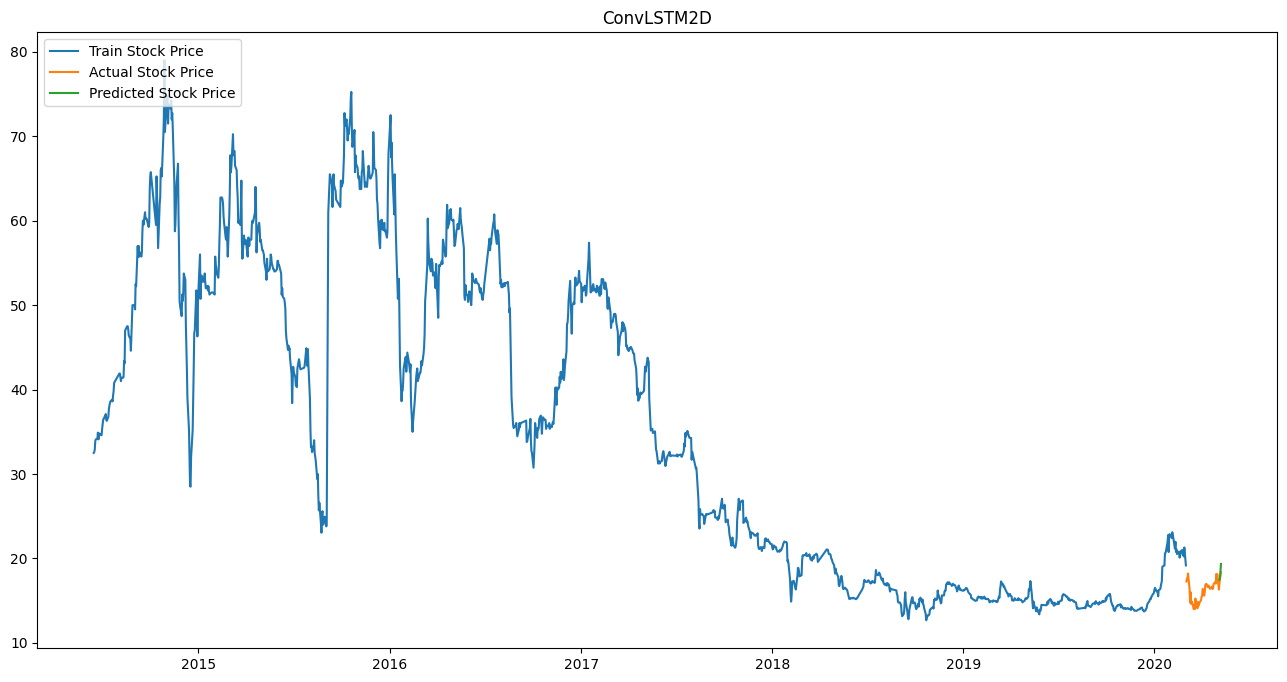

In [30]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.figure(figsize=(16,8))
price_close_train = Y_train[0]
price_close_test = Y_test[0]
plt.plot(train_date, price_close_train, label = "Train Stock Price")
plt.plot(test_date, price_close_test, label = "Actual Stock Price")
plt.plot(pred_date, Y_pred[0], label = "Predicted Stock Price")

plt.title("ConvLSTM2D")
plt.legend(loc='upper left')
#plt.tight_layout()

plt.show()

In [31]:
# Save a model
model.save('ConvLSTM2D_dataset3.h5')